# Book Recommendation System Operational Phase

Using the components from previous phases, we're going to use the system to get the book recommendation output. Here's the general flow of this step:
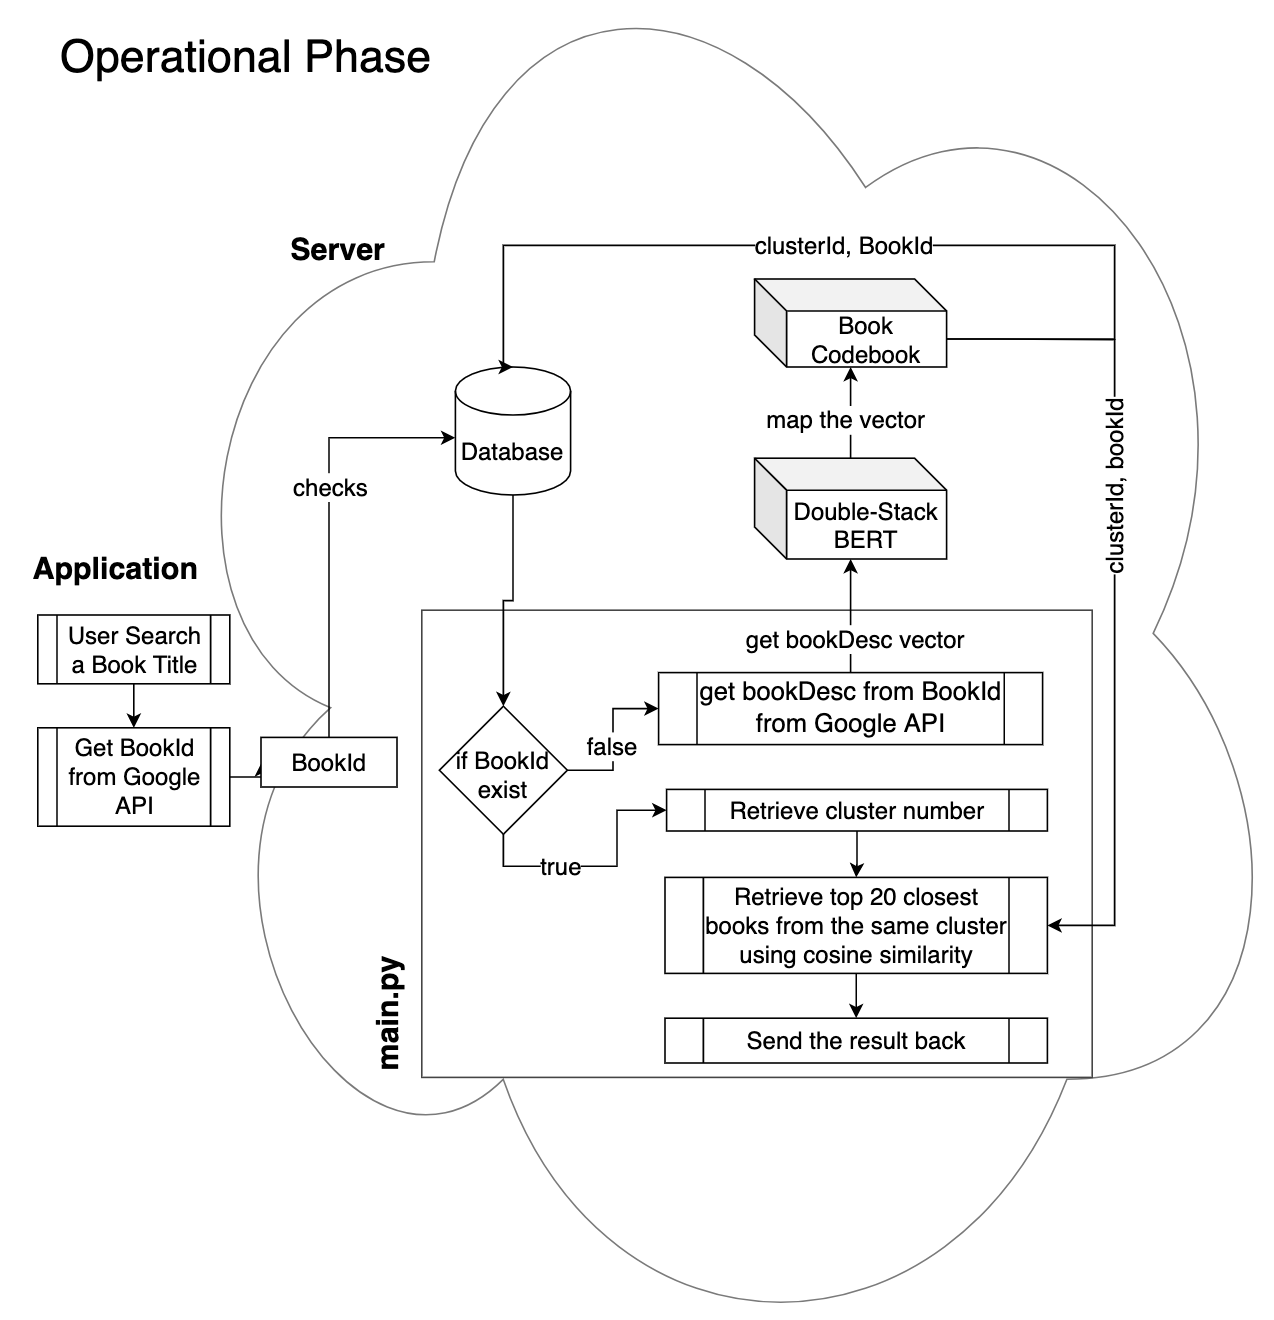

In [9]:
# ------------- Needed Libraries
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from scipy.cluster.vq import *
import pickle
import requests
import re
import torch
import math
import json
from sklearn.metrics.pairwise import cosine_similarity
from transformers import RobertaModel

def getElementsInTheSameCluster(centroidId):
    cluster = pd.read_csv('GoogleBooksAPIDataset_withCluster.csv')
    book_embeddings = np.load('book_embeddings.npy')
    cluster['embeddings_id'] = [i for i in range(0,book_embeddings.shape[0])]
    multiIndex_cluster = cluster.sort_values(by=['cluster'])
    multiIndex_cluster = multiIndex_cluster.set_index(['cluster','id']).drop(['Unnamed: 0'],axis=1)
    cluster_books = multiIndex_cluster.loc[centroidId]

    ids = np.asarray(cluster_books.index)
    titles = [t for t in cluster_books['title']]
    desc = [d for d in cluster_books['desc']]
    embeddings = [book_embeddings[id] for id in cluster_books['embeddings_id']]
    similar_books = {'id':ids, 'title':titles, 'desc':desc}
    return similar_books, embeddings

def most_similar(similarity_matrix):
    count = 0
    similar_ix=np.argsort(similarity_matrix)[::-1]
    similar_ix = similar_ix.reshape((similar_ix.shape[1],1))
    top_20 = np.asarray(similar_ix[0:min(20,len(similar_ix)-1)])
   
    return top_20

def getBookTitleAndDesc(bookId):
    url = 'https://www.googleapis.com/books/v1/volumes/'+bookId
    r = requests.get(url)
    title = ""
    desc = ""
    if r.status_code == 200: #if the request is successful
        r = r.json() #converting the JSON file into python's dictionary
        if 'title' in r['volumeInfo']:
            title = r['volumeInfo']['title']
        if 'description' in r['volumeInfo']:
            desc = r['volumeInfo']['description']
    return title, desc

In [2]:
class DoubleStackBERT:
    def __init__(self, tokenizer_source): 
        self.model = RobertaModel.from_pretrained('doublestackbert')
        self.codebook = np.load(tokenizer_source+'/codebook.npy')
        with open(tokenizer_source+'/vocabs.json') as json_file:
            self.__vocabs = json.load(json_file)
        self.sentenceTransformer = SentenceTransformer('all-mpnet-base-v2')
        self.bos_token = self.cls_token = '<s>'
        self.eos_token = self.sep_token = '</s>'
        self.unk_token = '<unk>'
        self.pad_token = '<pad>'
        self.mask_token = '<mask>'
        self.mask_token_id = self.__vocabs['<mask>']

        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        # and move our model over to the selected device
        self.model.to(self.device)
        
    def getVocabSize(self):
        return len(self.__vocabs)
  
    # splitting text into sentences
    # receives a string as parameter
    # returns an array of string(s)
    # library dependencies: re
    def __splitTextToSentences(self,text):
        try:
            arrayOfSentences = re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', text)
        except:
            arrayOfSentences = [""]
        return arrayOfSentences

    # Turns an array of raw text into each of it sentences embedding
    # receives a pretrained Sentence-BERT model and the intended dataset
    # returns 2D array. Each index contains a list of embedded strings
    # library dependencies: sentence_transformers
    # local function dependencies: splitTextToSentences  
    def __getSentencesEmbedding(self, dataset):
        # splitting eaxh text of the dataset into a list of sentences using previously made function
        array = []
        if type(dataset) == str: # if single query
            array.append(dataset)
        else: # if multiple queries
            array = dataset

        sentences_dataset = [self.__splitTextToSentences(text) for text in array]
        dataset_embeddings = []
        for i in range(len(sentences_dataset)):
            embeddings = self.sentenceTransformer.encode(sentences_dataset[i])
            dataset_embeddings.append(embeddings)

        return dataset_embeddings
  
    # Parameter: max_length, padding='max_length', truncation)
    def tokenize(self, list_of_docs, max_length= -1, padding = True, truncation = True): 
        docs_tokens = [] 
        doc_embeddings = self.__getSentencesEmbedding(list_of_docs)
        for doc in doc_embeddings:
            sentences_cluster_ids = vq(doc,self.codebook)
            sentences_token_ids = []
            attention_mask = []
            for cluster_id in sentences_cluster_ids[0]: 
                sentences_token_ids.append(self.__vocabs[str(cluster_id)])

            if truncation and max_length != -1 :
                if len(sentences_token_ids) + 2 > max_length:
                    sentences_token_ids = sentences_token_ids[:(max_length-2)]
                    padding = False

            input_ids = [self.__vocabs['<s>']] + sentences_token_ids + [self.__vocabs['</s>']]
            attention_mask.extend([1] * len(input_ids))

            if padding:
                padding_len = max_length - len(input_ids)
                input_ids.extend([self.__vocabs['<pad>']] * padding_len)
                attention_mask.extend([0] * padding_len)

            docs_tokens.append({'input_ids':input_ids, 'attention_mask':attention_mask})

        return docs_tokens

    def getTensors(self,dataset,max_length= -1, padding = True, truncation = True):
        tensors = []
        if type(dataset) is str:
            dataset = [dataset]
        for d in dataset:
            t = torch.tensor([self.tokenize(d,max_length,padding,truncation)[0]['input_ids']])
            output = self.model(t).pooler_output.cpu().detach().numpy()
            tensors.append(output.reshape((output.shape[1])))
        return tensors

    def getEmbeddings(self,dataset, max_length= -1, padding = True, truncation = True):
        if type(dataset) == str:
            dataset = [dataset]
        embeddings = self.sentenceTransformer.encode(dataset)
        tensors = self.getTensors(dataset,max_length,padding,truncation)
        return np.concatenate((embeddings, tensors), axis=1)

## Loading the components

In [4]:
model = DoubleStackBERT('doublestackbert_tokenizer')
bookCodebook = np.load("bookCodebook.npy")

Some weights of the model checkpoint at doublestackbert were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at doublestackbert and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Ask the query
Let's use 'No Longer Human' by Osamu Dazai as the query

In [29]:
# Takes book id as input
queryBookId = "9jhi2bY3GkAC" # the book id corresponds to the one in the Google Books database
# Getting the book's title and description
query_title, query_desc = getBookTitleAndDesc(queryBookId)

print("QUERY TITLE       :", query_title)
print("QUERY DESCRIPTION :", query_desc)

QUERY TITLE       : No Longer Human
QUERY DESCRIPTION : <p>The poignant and fascinating story of a young man who is caught between the breakup of the traditions of a northern Japanese aristocratic family and the impact of Western ideas.</p> Portraying himself as a failure, the protagonist of Osamu Dazai's No Longer Human narrates a seemingly normal life even while he feels himself incapable of understanding human beings. Oba Yozo's attempts to reconcile himself to the world around him begin in early childhood, continue through high school, where he becomes a "clown" to mask his alienation, and eventually lead to a failed suicide attempt as an adult. Without sentimentality, he records the casual cruelties of life and its fleeting moments of human connection and tenderness.


## Converting the synopsis to embeddings and getting its cluster id

In [30]:
# Converting the book desc into vector embedding
query_vector = model.getEmbeddings(query_desc)
# Getting the predicted cluster for our query
queryCluster, _ = vq(query_vector,bookCodebook)

In [31]:
print("Cluster id of query book:",queryCluster[0])

Cluster id of query book: 11


## Getting other books on the same cluster as our query

In [32]:
same_cluster_books, cluster_book_embeddings = getElementsInTheSameCluster(queryCluster[0])

In [33]:
print("Total books in the current cluster:", len(same_cluster_books['id']))

Total books in the current cluster: 111


## Getting the cosine similarity values between the query vector and the rest of embeddings in the same cluster and sorting it

In [34]:
# Getting its similarities matrix
pairwise_similarities=cosine_similarity(query_vector, cluster_book_embeddings)

In [35]:
# Get the most similar books in the cluster by sorting the cosine similarity values
similar_books = most_similar(pairwise_similarities)

## Result

In [36]:
# print the top 20 similar books
print("QUERY TITLE       :", query_title)
print("QUERY DESCRIPTION :", query_desc)
for i in range(len(similar_books)):
    print("=================================================================================")
    print("Title       :",same_cluster_books['title'][i])
    print("Description :",same_cluster_books['desc'][i])

QUERY TITLE       : No Longer Human
QUERY DESCRIPTION : <p>The poignant and fascinating story of a young man who is caught between the breakup of the traditions of a northern Japanese aristocratic family and the impact of Western ideas.</p> Portraying himself as a failure, the protagonist of Osamu Dazai's No Longer Human narrates a seemingly normal life even while he feels himself incapable of understanding human beings. Oba Yozo's attempts to reconcile himself to the world around him begin in early childhood, continue through high school, where he becomes a "clown" to mask his alienation, and eventually lead to a failed suicide attempt as an adult. Without sentimentality, he records the casual cruelties of life and its fleeting moments of human connection and tenderness.
Title       : Japanese American History
Description : Produced under the auspices of the Japanese American National Museum in Los Angeles, this comprehensive reference culls information from primary sources--Japanese-